In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from pygam import s, te, f, LogisticGAM
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

import xgboost as xgb

from src.data_generation import *
from src.analysis import compare_adversarial_training, ModelEvaluator
from src.utils import *
from src.plotting import visualize_feature_shifts




In [2]:
DATA_FOLDER = 'data'

# Parameter definition

num_samples = 1000
num_features = 3

# degree of the polinomio for the attribute relationship
degree = 2

In [3]:
# random multivariate

mean_train = [0.90920214, 0.81962487, 0.88819135]

covariance_train = np.array([[0.726318, 0.20240102, 0.52472545],
                             [0.20240102, 0.11392557, 0.0264108],
                             [0.52472545, 0.0264108, 1.05107627]])

# build the features sample
sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
# random coefficients (otherwise remove coef from build_poly_target and will be randomly generated)
coef = [-0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 0.4803476403769713, -0.10624889645240687, 
        0.3182084398201366, 0.6789895126695962, -0.791324832566177, 0.531479159887424, 0.49115959567000167]

y_train, coef_train = build_poly_target(sample_train, degree, coef)
df_train['Y'] = y_train

# check for balance
df_train['Y'].value_counts()

Y
1    516
0    484
Name: count, dtype: int64

In [4]:
# shifted random multivariate
mean_shift = attributes_quantile(df_train, 0.05)

covariance_shift = [[ 0.16309729,  0.19325742, -0.12621892],
                    [ 0.19325742,  0.25197638, -0.13972381],
                    [-0.12621892, -0.13972381,  0.19160666]]

# Initialize an empty dictionary to store the dataframes
df_dict = {}

# Iterate over mix_prob values
for mix_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    # Generate mixture sample
    sample_mix = build_mixture_sample(num_samples, mean_train, covariance_train, mean_shift, covariance_shift, mix_prob=mix_prob)

    # Create a DataFrame for the features
    df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])

    # Build the target variable y
    y_mix, coef_mix = build_poly_target(sample_mix, degree, coefficients=coef_train)
    df_mix['Y'] = y_mix

    # Store the DataFrame in the dictionary
    df_dict[mix_prob] = df_mix

In [5]:
# Create a folder
folder_name = os.path.join('data')
os.makedirs(folder_name, exist_ok=True)

for mix_prob, df in df_dict.items():
    df.to_csv(os.path.join(folder_name, f'mix_{mix_prob}.csv'), index=False)
file_name = 'Parameters.txt'
file_path = os.path.join(folder_name, file_name)
df_train.to_csv(os.path.join(folder_name, 'train.csv'), index=False)

with open(file_path, 'w') as f:
  f.write('Polinomial coefficients\n')
  f.write(f'{coef_train}\n')
  f.write('Mean train\n')
  f.write(f'{mean_train}\n')
  f.write('Covariance train\n')
  f.write(f'{covariance_train}\n')
  f.write('Mean shift\n')
  f.write(f'{mean_shift}\n')
  f.write('Covariance shift\n')
  f.write(f'{covariance_shift}\n')

In [6]:
from typing import Optional, Tuple, Union

from sklearn.base import BaseEstimator
from src.robust_training.mechanistic import MechanisticTrainer
try:
    from pygam import LogisticGAM
    PYGAM_AVAILABLE = True
except ImportError:
    PYGAM_AVAILABLE = False


def run_mechanistic_robust_training_and_eval(
    folder: str = "dat",
    target: str = 'Y',
    n_rounds: int = 2,
    model_type: str = 'gbc',  # Options: 'gbc', 'tree', 'gam'
    base_shift_factor: float = 5,
    fraction_to_shift: float = 0.9,
    final_train_size: Optional[int] = None,
    random_state: int = 42,
    noise_scale: float = 0.001,
    n_grad_steps: int = 1,
    top_k: int = 3,
    eps = 0.2, 
    ball = False
) -> Tuple[BaseEstimator, BaseEstimator]:
    """
    Trains both a baseline model and a robust model using MechanisticTrainer,
    then evaluates both models on all shifted test files in the specified folder.

    Parameters
    ----------
    folder : str
        Directory containing 'train.csv' for training and 'mix_<n>.csv' for testing.
    target : str
        Name of the target variable in the datasets.
    n_rounds : int
        Number of augmentation rounds for MechanisticTrainer.
    model_type : str
        Type of model to use for robust training. Options: 'gbc', 'tree', 'gam'.
    base_shift_factor : float
        Magnitude by which to shift selected features during augmentation.
    fraction_to_shift : float
        Fraction of the dataset to select for augmentation each round.
    final_train_size : int or None
        If specified, downsample the final training set to this size.
    random_state : int
        Seed for reproducibility.
    noise_scale : float
        Standard deviation of Gaussian noise added to augmented samples.
    n_grad_steps : int
        Number of gradient-based steps per sample during augmentation.
    top_k : int
        Number of top features (by gradient magnitude) to shift per sample.

    Returns
    -------
    baseline_model : BaseEstimator
        The baseline model trained on the original data.
    robust_model : BaseEstimator
        The robustly trained model using MechanisticTrainer.
    """

    # ----------------------------------------------------------------------
    # 1) Load original training data from "mix_0.0.csv"
    # ----------------------------------------------------------------------
    train_file = os.path.join(folder, "train.csv")
    if not os.path.exists(train_file):
        raise FileNotFoundError(f"Training file '{train_file}' not found in folder '{folder}'.")

    df_orig = pd.read_csv(train_file)
    if target not in df_orig.columns:
        raise ValueError(f"Target column '{target}' not found in '{train_file}'.")

    X_train = df_orig.drop(columns=[target])
    y_train = df_orig[target]

    print(f"Loaded training data from '{train_file}' with shape = {X_train.shape}")

    # ----------------------------------------------------------------------
    # 2) Train Baseline Model
    #    Ensure baseline uses the same model_type for fair comparison.
    # ----------------------------------------------------------------------
    print("\n=== Training Baseline Model ===")
    if model_type == 'gbc':
        baseline_model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,                        # default 3 ma fa pena, a 10 ha migliore AUC ma comunque minore f1, a 4/5 è fair
            random_state=random_state
        )
    elif model_type == 'tree':
        baseline_model = DecisionTreeClassifier(
            max_depth=10,                       # default 5 ma fa pena, a 10 ha peggiore AUC e comunque minore f1 ma è fair
            random_state=random_state
        )
    elif model_type == 'gam':
        if not PYGAM_AVAILABLE:
            raise ImportError("pyGAM is not installed. Install it via `pip install pygam` or choose another model type.")
        baseline_model = LogisticGAM( verbose=False)
        
    elif model_type == 'rfc':
        baseline_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,                   # default 5 ma fa pena, a 10 ha peggiore AUC e comunque minore f1 ma è fair
            random_state=random_state
        )
    
    else:
        raise ValueError(f"Unsupported model_type '{model_type}'. Choose from ['gbc', 'tree', 'gam'].")

    baseline_model.fit(X_train, y_train)
    
    print("Baseline model trained.")
    # Check class distribution in shifted data
    df_shifted = pd.read_csv('data/mix_1.0.csv')
    print("Class distribution in shifted data:")
    print(df_shifted['Y'].value_counts(normalize=True))

    # Check model predictions
    y_pred = baseline_model.predict(df_shifted.drop('Y', axis=1))
    print("\nPrediction distribution:")
    print(pd.Series(y_pred).value_counts(normalize=True))
    

    # ----------------------------------------------------------------------
    # 3) Train Mechanistic-Interpretability-Guided Robust Model
    # ----------------------------------------------------------------------
    print("\n=== Training Mechanistic-Interpretability-Guided Robust Model ===")
    trainer = MechanisticTrainer(
        model_type=model_type,         # 'gbc', 'tree', 'gam'
        base_shift_factor=base_shift_factor,
        n_rounds=n_rounds,
        fraction_to_shift=fraction_to_shift,
        n_grad_steps=n_grad_steps,
        top_k=top_k,
        random_state=random_state,
        noise_scale=noise_scale,
       
        val_fraction=0.1,               # Fraction for validation split
        eps = eps,
        ball = ball
    )



    # Fit the robust model
    trainer.fit(X_train, y_train)
    robust_model = trainer.model
    print("Robust model trained.")

    # If final_train_size is specified, downsample & refit
    if final_train_size is not None and final_train_size < len(trainer.X_final):
        rng = np.random.RandomState(random_state)
        idx_down = rng.choice(len(trainer.X_final), size=final_train_size, replace=False)
        X_down = trainer.X_final.iloc[idx_down].reset_index(drop=True)
        y_down = trainer.y_final.iloc[idx_down].reset_index(drop=True)
        robust_model.fit(X_down, y_down)
        print(f"Final training set downsampled to {final_train_size} samples.")
        # Check class distribution in shifted data
    df_shifted = pd.read_csv('data/mix_1.0.csv')
    print("Class distribution in shifted data:")
    print(df_shifted['Y'].value_counts(normalize=True))

    # Check model predictions
    y_pred = robust_model.predict(df_shifted.drop('Y', axis=1))
    print("\nPrediction distribution:")
    print(pd.Series(y_pred).value_counts(normalize=True))

    # ----------------------------------------------------------------------
    # 4) Evaluate on all shifted test files: "mix_<n>.csv"
    # ----------------------------------------------------------------------
    test_files = [
        f for f in os.listdir(folder)
        if f.startswith("mix_") and f.endswith(".csv") 
    ]

    if not test_files:
        print(f"\nNo shifted test files found in '{folder}' for evaluation.")
        return baseline_model, robust_model

    print("\n=== Evaluation on Shifted Test Files ===")
    for test_file in sorted(test_files):
        test_path = os.path.join(folder, test_file)
        df_test = pd.read_csv(test_path)
        if target not in df_test.columns:
            print(f"Skipping '{test_file}': missing target '{target}'.")
            continue

        X_test = df_test.drop(columns=[target])
        y_test = df_test[target]

        # Evaluate Baseline Model
        y_pred_b = baseline_model.predict(X_test)
        if hasattr(baseline_model, "predict_proba"):
            y_proba_b = baseline_model.predict_proba(X_test)[:, 1]
            try:
                auc_b = roc_auc_score(y_test, y_proba_b)
            except ValueError:
                auc_b = "N/A (only one class present)"
        else:
            y_proba_b = None
            auc_b = "N/A"

        acc_b = accuracy_score(y_test, y_pred_b)
        f1_b = f1_score(y_test, y_pred_b) 

        # Evaluate Robust Model
        y_pred_r = robust_model.predict(X_test)
        if hasattr(robust_model, "predict_proba"):
            y_proba_r = robust_model.predict_proba(X_test)[:, 1]
            try:
                auc_r = roc_auc_score(y_test, y_proba_r)
            except ValueError:
                auc_r = "N/A (only one class present)"
        else:
            y_proba_r = None
            auc_r = "N/A"

        acc_r = accuracy_score(y_test, y_pred_r)
        f1_r = f1_score(y_test, y_pred_r) 
        print(f"\nTest File: {test_file}")
        print(f"  Baseline Model => Accuracy: {acc_b:.3f}, F1 Score: {f1_b:.3f}, AUC: {auc_b}")
        print(f"  Robust Model   => Accuracy: {acc_r:.3f}, F1 Score: {f1_r:.3f}, AUC: {auc_r}")
        print("-" * 50)

        print(f"\nTest File: {test_file}: delta AUC r-b (hope > 0): {auc_r - auc_b}")

    return baseline_model, robust_model



In [ ]:
DATA_FOLDER = 'data'
TARGET_COLUMN = 'Y'

# Run the robust training and evaluation
baseline_model, robust_model = run_mechanistic_robust_training_and_eval(
    folder=DATA_FOLDER,
    target=TARGET_COLUMN,
    n_rounds=1,
    model_type='tree',          # Options: 'gbc', 'tree', 'gam', 'rfc'
    base_shift_factor=4,    
    fraction_to_shift=0.5,      # 0.9 better for rfc
       
    random_state=42,
    noise_scale=0.01,
    n_grad_steps=1,
    top_k=3, 
    eps=0.1,
    ball=False
)


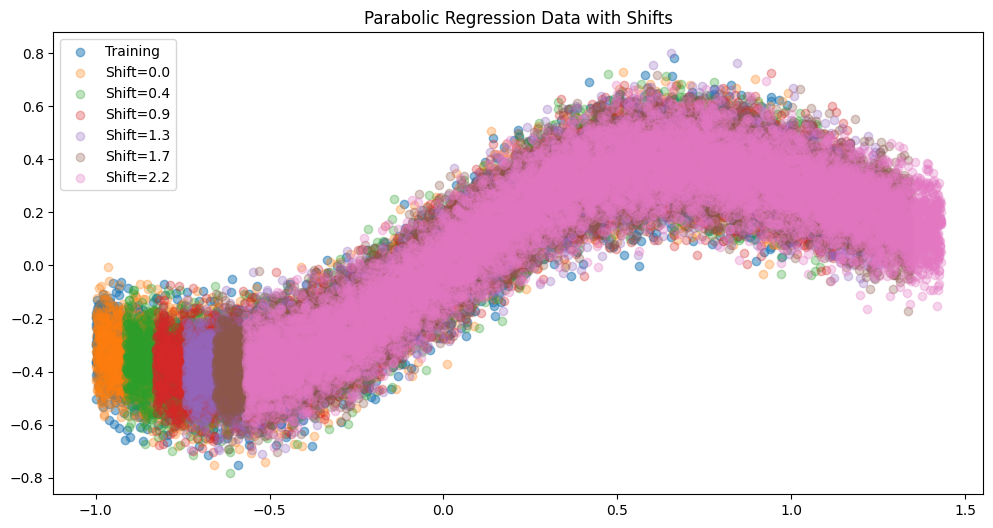

Training baseline model...

Training robust model...
[MechanisticTrainer] Initial fit on full dataset.
[MechanisticTrainer] Augmentation Round 1/1
  => Augmenting 10000 samples.
  => Augmented pool size: 20000 samples
  => Downsampled combined data to 10000 total samples.
[MechanisticTrainer] Robust model training completed.


=== Evaluation on Shifted Test Sets ===

Shift 0.00:
  Baseline MSE: 0.010
  Robust MSE: 0.015
  Improvement: -50.1%

Shift 0.09:
  Baseline MSE: 0.010
  Robust MSE: 0.016
  Improvement: -60.6%

Shift 0.17:
  Baseline MSE: 0.010
  Robust MSE: 0.017
  Improvement: -66.4%

Shift 0.26:
  Baseline MSE: 0.010
  Robust MSE: 0.016
  Improvement: -61.1%

Shift 0.34:
  Baseline MSE: 0.010
  Robust MSE: 0.017
  Improvement: -59.7%

Shift 0.43:
  Baseline MSE: 0.011
  Robust MSE: 0.018
  Improvement: -64.7%

Shift 0.52:
  Baseline MSE: 0.012
  Robust MSE: 0.021
  Improvement: -71.7%

Shift 0.60:
  Baseline MSE: 0.013
  Robust MSE: 0.024
  Improvement: -80.1%

Shift 0.69:
  

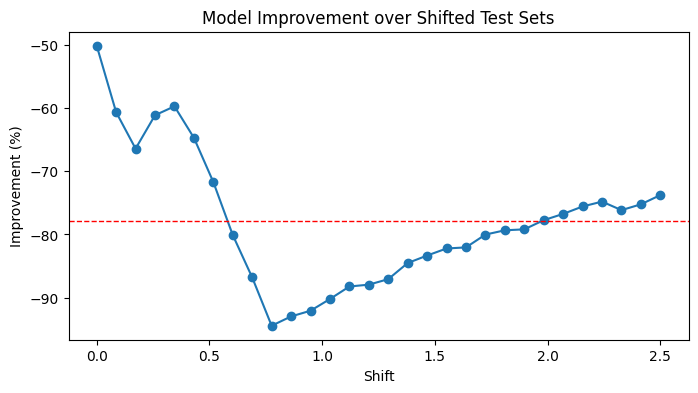

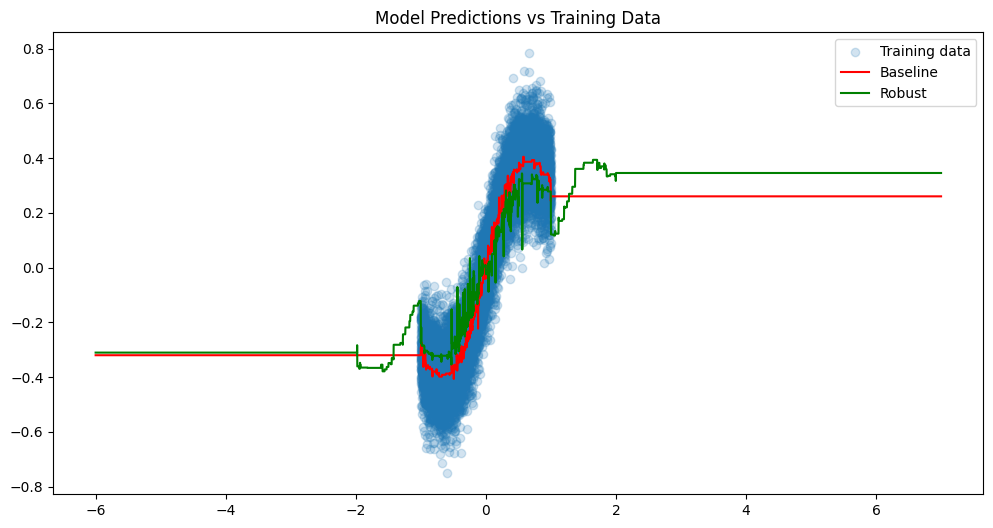

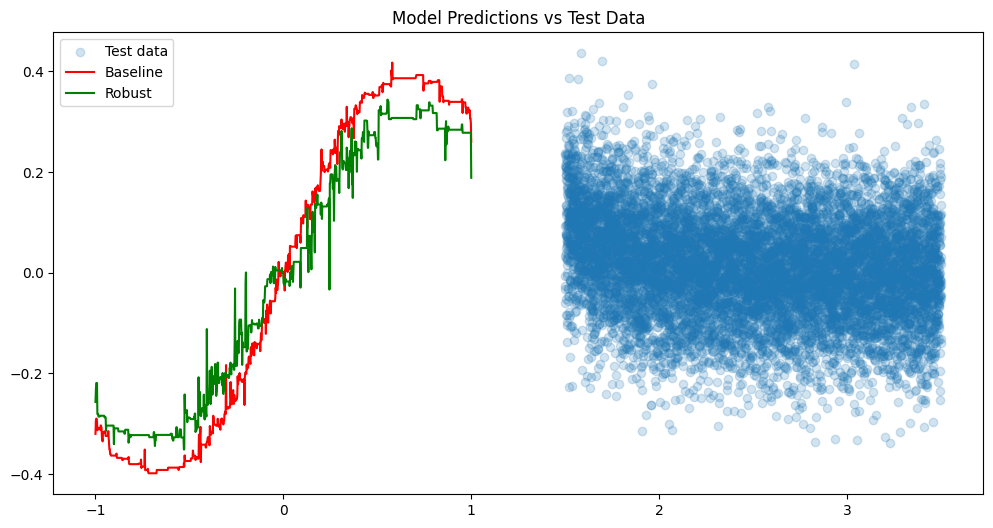

In [23]:
from sklearn.metrics import mean_squared_error
from typing import Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from src.robust_training.mechanistic import MechanisticTrainer
from numpy import sin, cos


def run_mechanistic_direct_eval(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    test_sets: list,
    shifts: np.ndarray,
    model_type: str = 'gbr',
    n_rounds: int = 1,
    base_shift_factor: float = 0.1,
    fraction_to_shift: float = 0.7,
    random_state: int = 42,
    noise_scale: float = 0.01,
    n_grad_steps: int = 1,
    top_k: int = 1,
    eps: float = 0.1,
    ball: bool = False
) -> Tuple[BaseEstimator, BaseEstimator]:
    """Modified version to work directly with DataFrames instead of CSV files"""
    
    # Initialize baseline model
    if model_type == 'gbr':
        from sklearn.ensemble import GradientBoostingRegressor
        baseline_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=5,
            random_state=random_state
        )
    elif model_type == 'tree':
        from sklearn.tree import DecisionTreeRegressor

        baseline_model = DecisionTreeRegressor(
            max_depth=5,
            random_state=random_state
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Train baseline
    print("Training baseline model...")
    baseline_model.fit(X_train, y_train)

    # Train robust model
    print("\nTraining robust model...")
    trainer = MechanisticTrainer(
        model_type=model_type,
        base_shift_factor=base_shift_factor,
        n_rounds=n_rounds,
        fraction_to_shift=fraction_to_shift,
        n_grad_steps=n_grad_steps,
        top_k=top_k,
        random_state=random_state,
        noise_scale=noise_scale,
        val_fraction=0.1,
        eps=eps,
        ball=ball,
        task='regression'
    )
    
    trainer.fit(X_train, y_train)
    robust_model = trainer.model

    # Evaluate on test sets
    print("\n=== Evaluation on Shifted Test Sets ===")
    improvements = []
    for (X_test, y_test), shift in zip(test_sets, shifts):
        mse_baseline = mean_squared_error(y_test, baseline_model.predict(X_test))
        mse_robust = mean_squared_error(y_test, robust_model.predict(X_test))
        improvement = (mse_baseline - mse_robust) / mse_baseline * 100
        improvements.append(improvement)
        
        print(f"\nShift {shift:.2f}:")
        print(f"  Baseline MSE: {mse_baseline:.3f}")
        print(f"  Robust MSE: {mse_robust:.3f}")
        print(f"  Improvement: {improvement:.1f}%")
     
    # mse_baseline_y = mean_squared_error(y_testy, baseline_model.predict(X_testy))
    # mse_robust_y = mean_squared_error(y_testy, robust_model.predict(X_testy))
    # improvement_y = (mse_baseline - mse_robust) / mse_baseline * 100
    # print(f"  Baseline MSE-----: {mse_baseline_y:.3f}")
    # print(f"  Robust MSE-----: {mse_robust_y:.3f}")
    # print(f"  Improvement-----: {improvement_y:.1f}%")
     

    plt.figure(figsize=(8, 4))
    plt.plot(shifts, improvements, marker='o')
    plt.axhline(np.mean(improvements), color='red', linestyle='--', lw=1)
    plt.xlabel("Shift")
    plt.ylabel("Improvement (%)")
    plt.title("Model Improvement over Shifted Test Sets")
    plt.show()

    return baseline_model, robust_model

RND=108
np.random.seed(RND)
x = np.linspace(-1, 1, 10000)
y =np.sin(x)*np.exp(-x**2) + np.random.normal(0, 0.1, 10000)
X_train = pd.DataFrame({'X1': x})
y_train = pd.Series(y)

# x_t = np.linspace(-4.99, 4.99, 10000)
# y_t = x_t**2 + np.random.normal(0, 5, 10000)

# X_testy = pd.DataFrame({'X1': x_t })
# y_testy = pd.Series(y_t)

shifts = np.linspace(0, 2.5, 30)
test_sets = []
for shift in shifts:
    x_shifted = x + shift
    y_shifted = np.sin(x_shifted)*np.exp(-x_shifted**2) + np.random.normal(0, 0.1, 10000)
    test_sets.append((
        pd.DataFrame({'X1': x_shifted}),
        pd.Series(y_shifted)
    ))

plt.figure(figsize=(12, 6))
plt.scatter(X_train['X1'], y_train, alpha=0.5, label='Training')
for i, shift in enumerate(shifts[::5]):  
    X_test, y_test = test_sets[i]
    plt.scatter(X_test['X1'], y_test, alpha=0.3, label=f'Shift={shift:.1f}')
plt.legend()
plt.title('Parabolic Regression Data with Shifts')
plt.show()

# Run evaluation
baseline_model, robust_model = run_mechanistic_direct_eval(
    X_train=X_train,
    y_train=y_train,
    test_sets=test_sets,
    shifts=shifts,
    model_type='gbr',
    n_rounds=1,
    base_shift_factor=1,  
    fraction_to_shift=0.4,
    random_state=42,
    noise_scale=0.,
    n_grad_steps=1,
    top_k=1,
    eps=0.05,
    ball=False,
)

# Plot predictions
plt.figure(figsize=(12, 6))
x_plot = np.linspace(-6, 7, 10000)  
X_plot = pd.DataFrame({'X1': x_plot})

plt.scatter(X_train['X1'], y_train, alpha=0.2, label='Training data')
plt.plot(x_plot, baseline_model.predict(X_plot), 'r-', label='Baseline')
plt.plot(x_plot, robust_model.predict(X_plot), 'g-', label='Robust')
plt.legend()
plt.title('Model Predictions vs Training Data')
plt.show()

plt.figure(figsize=(12, 6)) 
x_plot = np.linspace(-1, 1, 1000)  # Extended range to show shifts
X_plot = pd.DataFrame({'X1': x_plot})

#plot scatter on last shift
X_test, y_test = test_sets[-1]
plt.scatter(X_test['X1'], y_test, alpha=0.2, label='Test data')
plt.plot(x_plot, baseline_model.predict(X_plot), 'r-', label='Baseline')
plt.plot(x_plot, robust_model.predict(X_plot), 'g-', label='Robust')
plt.legend()
plt.title('Model Predictions vs Test Data')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from typing import Optional, Tuple, Union
from sklearn.base import BaseEstimator

from src.robust_training.mechanistic import MechanisticTrainer
from numpy import sin, cos

def run_mechanistic_direct_eval(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    test_sets: list,
    shifts: np.ndarray,
    model_type: str = 'gbr',
    n_rounds: int = 1,
    base_shift_factor: float = 0.1,
    fraction_to_shift: float = 0.7,
    random_state: int = 42,
    noise_scale: float = 0.01,
    n_grad_steps: int = 1,
    top_k: int = 1,
    eps: float = 0.1,
    ball: bool = False,
    plot: bool = False  # flag to disable plotting
) -> Tuple[BaseEstimator, BaseEstimator, float]:
    """Modified version to work directly with DataFrames and return the average improvement.
       The `plot` flag controls whether to show plots (should be False when running multiple times).
    """
    
    # Initialize baseline model
    if model_type == 'gbr':
        from sklearn.ensemble import GradientBoostingRegressor
        baseline_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=5,
            random_state=random_state
        )
    elif model_type == 'tree':
        from sklearn.tree import DecisionTreeRegressor
        baseline_model = DecisionTreeRegressor(
            max_depth=10,
            random_state=random_state
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Train baseline model
    print("Training baseline model...")
    baseline_model.fit(X_train, y_train)

    # Train robust model
    print("Training robust model...")
    trainer = MechanisticTrainer(
        model_type=model_type,
        base_shift_factor=base_shift_factor,
        n_rounds=n_rounds,
        fraction_to_shift=fraction_to_shift,
        n_grad_steps=n_grad_steps,
        top_k=top_k,
        random_state=random_state,
        noise_scale=noise_scale,
        val_fraction=0.1,
        eps=eps,
        ball=ball,
        task='regression'
    )
    trainer.fit(X_train, y_train)
    robust_model = trainer.model

    # Evaluate on test sets
    print("=== Evaluation on Shifted Test Sets ===")
    improvements = []
    for (X_test, y_test), shift in zip(test_sets, shifts):
        mse_baseline = mean_squared_error(y_test, baseline_model.predict(X_test))
        mse_robust = mean_squared_error(y_test, robust_model.predict(X_test))
        improvement = (mse_baseline - mse_robust) / mse_baseline * 100
        improvements.append(improvement)

        print(f"Shift {shift:.2f}: Baseline MSE = {mse_baseline:.3f}, Robust MSE = {mse_robust:.3f}, Improvement = {improvement:.1f}%")
        
    avg_improvement = np.mean(improvements)
    print(f"Average Improvement: {avg_improvement:.2f}%")

    # Plot only if requested
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(shifts, improvements, marker='o')
        plt.axhline(avg_improvement, color='red', linestyle='--', lw=1)
        plt.xlabel("Shift")
        plt.ylabel("Improvement (%)")
        plt.title("Model Improvement over Shifted Test Sets")
        plt.show()
        plt.close('all')  # ensure figures are closed

    return baseline_model, robust_model, avg_improvement




# Run the evaluation 20 times with different random seeds and count positive average improvements
n_runs = 15
positive_count = 0
avg_improvements = []

for run in range(n_runs):
    curr_seed = 123 + run  # different seed each run
    print(f"\n=== Run {run+1} with dataset random seed={curr_seed} ===")
    
    
    np.random.seed(curr_seed)
    x = np.linspace(-5, 5, 1000)
    y = x**2 + np.random.normal(0, 1, 1000)
    X_train = pd.DataFrame({'X1': x})
    y_train = pd.Series(y)

    # Create shifted test sets
    shifts = np.linspace(4.5, 5.5, 30)
    test_sets = []
    for shift in shifts:
        x_shifted = x + shift
        y_shifted = x_shifted**2 + np.random.normal(0, 1, 1000)
        test_sets.append((
            pd.DataFrame({'X1': x_shifted}),
            pd.Series(y_shifted)
        ))
    # Pass plot=False to disable plotting
    _, _, avg_impr = run_mechanistic_direct_eval(
        X_train=X_train,
        y_train=y_train,
        test_sets=test_sets,
        shifts=shifts,
        model_type='gbr',
        n_rounds=1,
        base_shift_factor=0.01,  
        fraction_to_shift=0.4,
        random_state=42,
        noise_scale=0.,
        n_grad_steps=5,
        top_k=1,
        eps=0.05,
        ball=True,
        plot=False
    )
    #ok per gbr
    # n_rounds=1,
    #     base_shift_factor=0.01,  
    #     fraction_to_shift=0.5,
    #     random_state=curr_seed,
    #     noise_scale=0.0,
    #     n_grad_steps=5,
    #     top_k=1,
    #     eps=0.05,
    #     ball=True,
    #     plot=False
    
    avg_improvements.append(avg_impr)
    if avg_impr > 0:
        positive_count += 1

    # Clear the current figure to ensure no memory leaks
    plt.close('all')


print("\n=== Summary ===")
print(f"Number of runs with positive average improvement: {positive_count} out of {n_runs}")
